# Классификация Oxford Pets

Обучим сеть для классификации исходного датасета [Oxford-IIIT Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/). Загрузите датасет с Kaggle.

Импорт библиотек

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import torch
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import top_k_accuracy_score
import cv2
from PIL import Image
import copy

Задаём необходимые параметры

In [6]:
SEED = 3000
np.random.seed(SEED)
torch.random.manual_seed(SEED)
torch.cuda.random.manual_seed_all(SEED)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

Загружаем датасет из директории images и размечаем его на классы

In [7]:
images = os.listdir(r"C:\gm\images")

def get_class(string):
    for i, ch in enumerate(string):
        if ch.isdigit():
            return string[:i-1]
        

classes = list(set([get_class(img) for img in images if get_class(img) is not None]))

Разделим датасет на обучающую и тестовую выборки

In [8]:
shutil.rmtree('./dataset')
os.makedirs('./dataset')
os.makedirs('./dataset/train')
os.makedirs('./dataset/test')
val_size = 0.2

for cl in classes:
    os.makedirs(os.path.join('dataset/train', cl))
    os.makedirs(os.path.join('dataset/test', cl))

for i, image in enumerate(images):
    cur_class = get_class(image)
    if cur_class is None:
        continue
    if np.random.random(1) < 1 - val_size:
        shutil.copy(os.path.join(r"C:\gm\images", image), os.path.join('dataset/train', cur_class))
    else:
        shutil.copy(os.path.join(r"C:\gm\images", image), os.path.join('dataset/test', cur_class))

Немного покрутим изображения для более высокой точности и создадим dataloaders

In [9]:
transform = transforms.Compose([
                                transforms.Resize((128, 128)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ])

train_set = datasets.ImageFolder('./dataset/train', transform=transform)
test_set = datasets.ImageFolder('./dataset/test', transform=transform)

batch_size = 64

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=True)

Основная функция для обучения сети. Она будет дообучать модули VGG-16, VGG-19 и ResNet. Принимает на вход модель и выборки, после чего происходит обучение и получение необходимых метрик

In [10]:
def train_model(model, train_loader, test_loader, epochs_num, optimizer, criterion, device):
    train_loss_history = []
    test_loss_history = []
    train_acc_history = []
    test_acc_history = []

    for _ in range(epochs_num):
        cur_train_acc = 0
        cur_test_acc = 0

        cur_train_loss = 0
        cur_test_loss = 0

        model.train()
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            cur_train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            cur_train_acc += (y_batch.squeeze() == torch.argmax(y_pred, axis=1)).cpu().numpy().sum()
            
        model.eval()
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                
                y_pred = model(X_batch)
                cur_test_acc += (y_batch.squeeze() == torch.argmax(y_pred, axis=1)).cpu().numpy().sum()

                loss = criterion(y_pred, y_batch)
                cur_test_loss += loss.cpu().item()

        
        train_acc_history.append(cur_train_acc / (len(train_loader) * batch_size))
        test_acc_history.append(cur_test_acc / (len(test_loader) * batch_size))
        train_loss_history.append(cur_train_loss / (len(train_loader) * batch_size))
        test_loss_history.append(cur_test_loss / (len(test_loader) * batch_size))
    
    return train_loss_history, test_loss_history, train_acc_history, test_acc_history

Задаём 3 классификатора и дообучаем их. Эпох я задал совсем мало, потмоу что точность существенно не повышается, а времени требуется гораздо больше

In [11]:
epochs = 2
criterion = nn.CrossEntropyLoss()

vgg16 = models.vgg16(pretrained=True)
vgg16.classifier[6] = nn.Linear(4096, len(classes))
vgg16 = vgg16.to(device)
optimizer = torch.optim.Adam(vgg16.parameters(), lr=1e-4)
vgg16_stats = train_model(vgg16, train_loader, test_loader, epochs, optimizer, criterion, device)

vgg19 = models.vgg19(pretrained=True)
vgg19.classifier[6] = nn.Linear(4096, len(classes))
vgg19 = vgg19.to(device)
optimizer = torch.optim.Adam(vgg19.parameters(), lr=1e-4)
vgg19_stats = train_model(vgg19, train_loader, test_loader, epochs, optimizer, criterion, device)

resnet = models.resnet18(pretrained=True)
resnet.fc = nn.Linear(512, len(classes))
resnet = resnet.to(device)
optimizer = torch.optim.Adam(resnet.parameters(), lr=1e-4)
resnet_stats = train_model(resnet, train_loader, test_loader, epochs, optimizer, criterion, device)

c:\Users\nikit\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nikit\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\nikit\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1

Для упрощения кода создадим 3 функции: для построения графика, confusion matrix и подсчёта k-метрики, где k подаётся на вход

In [12]:
def graf(title, label1, label2, val1, val2):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.plot(range(1, len(val1) + 1), val1, linewidth=2, label=label1)
    plt.plot(range(1, len(val2) + 1), val2, linewidth=2, label=label2)
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

def plot_confusion_matrix(model, test_loader):
    preds = None
    reals = None
    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            y_pred = model(X_batch)
            if preds is None:
                preds = torch.argmax(y_pred, axis=1).cpu().numpy()
                reals = y_batch.cpu().numpy()
            else:
                preds = np.hstack([preds, torch.argmax(y_pred, axis=1).cpu().numpy()])
                reals = np.hstack([reals, y_batch.cpu().numpy()])

    confustion_matrix = confusion_matrix(reals, preds)
    df_cm = pd.DataFrame(confustion_matrix, index = [i for i in classes], columns = [i for i in classes])
    plt.figure(figsize = (8, 8))
    sns.heatmap(df_cm, annot=True)
    plt.show()

def get_top_k_accuracy(model, val, k):
    preds = None
    reals = None
    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in val:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            y_pred = model(X_batch)
            if preds is None:
                preds = y_pred.cpu().numpy()
                reals = y_batch.cpu().numpy()
            else:
                preds = np.vstack([preds, y_pred.cpu().numpy()])
                reals = np.concatenate([reals, y_batch.cpu().numpy()])
    return top_k_accuracy_score(reals, preds, k=k)

Заметим особенность датасета: названия пород кошек начинаются с большой буквы, а собак - с маленькой. Пользуясб этим, разметим два класса: кошки и собаки. Посчитаем точность бинарной классификации, как мы это сделали в первой части ЛР

In [13]:
class_cats = []
class_dogs = []

for i in range(len(classes)):
    if classes[i][0].isupper():
        class_cats.append(i)
    else:
        class_dogs.append(i)

correct, total = 0, 0

for x, y in test_loader:
    x = x.to(device)
    y = y.to(device)
    y_pred = resnet(x)
    y_pred = torch.argmax(y_pred, axis=1).cpu().numpy()
    y = y.cpu().numpy()
    correct_cats = sum([y_pred[i] in class_cats and y[i] in class_cats for i in range(len(y))])
    correct_dogs = sum([y_pred[i] in class_dogs and y[i] in class_dogs for i in range(len(y))])
    correct += correct_cats + correct_dogs
    total += y.shape[0]

Вывод метрик для трёх классификаторов, а также для бинарной классификации

In [14]:
print('Final VGG-16 accuracy =', vgg16_stats[3][-1])
print('Final VGG-19 accuracy =', vgg19_stats[3][-1])
print('Final ResNet accuracy =', resnet_stats[3][-1])

print('\nBinary classification accuracy:', correct / total)

Final VGG-16 accuracy = 0.8254076086956522
Final VGG-19 accuracy = 0.8070652173913043
Final ResNet accuracy = 0.8023097826086957

Binary classification accuracy: 0.9279891304347826


Как видно, лучшая точность достигается у VGG-16. Однако он и обучался дольше, но в общем точность ResNet выше, поэтому используем его для вывода k-метрик и матрицы. Построим графики

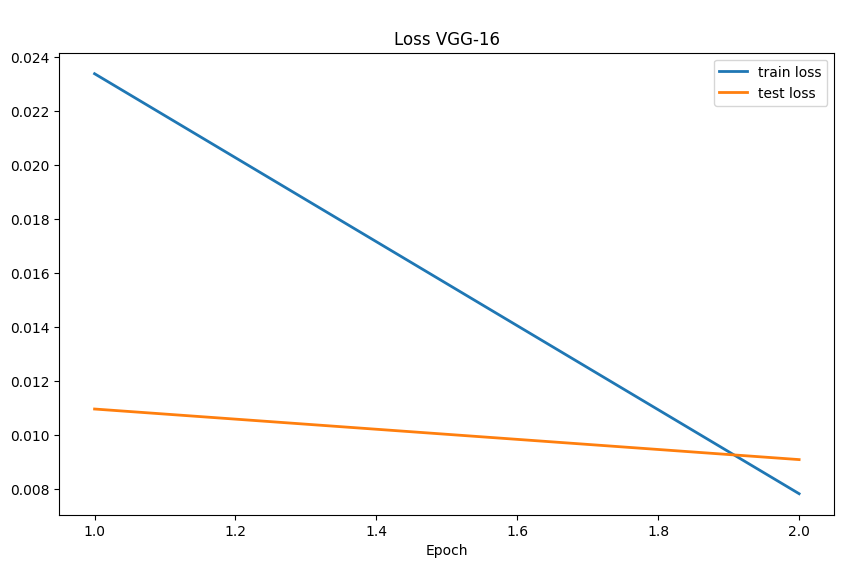

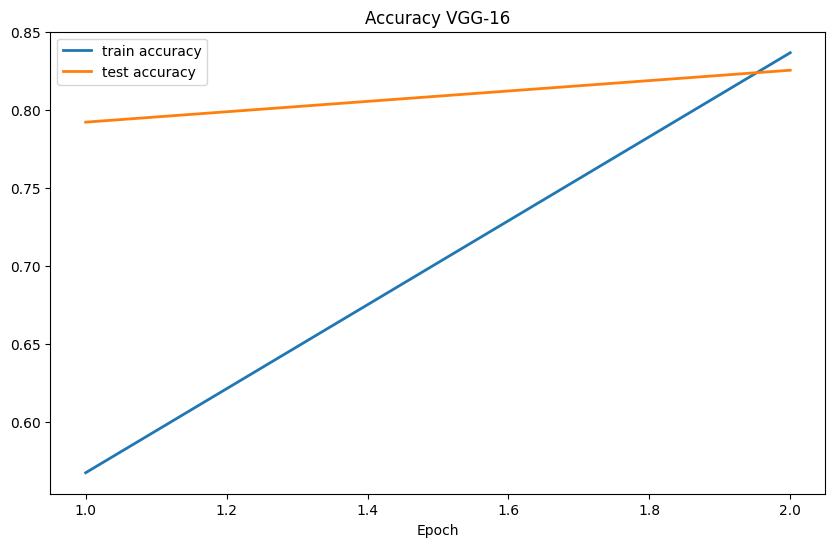

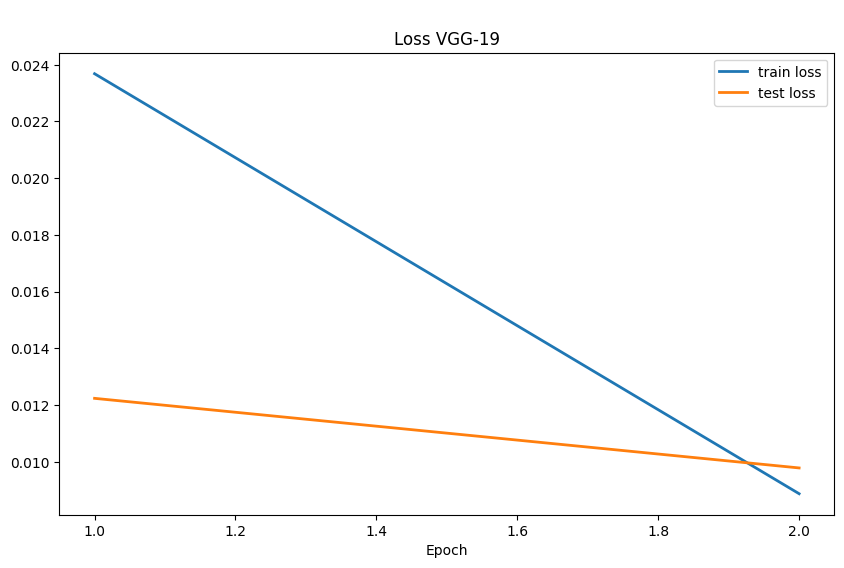

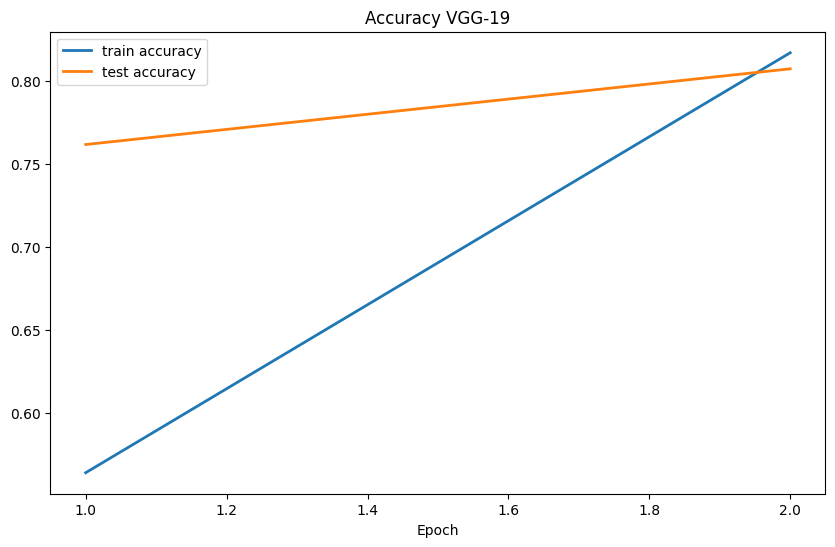

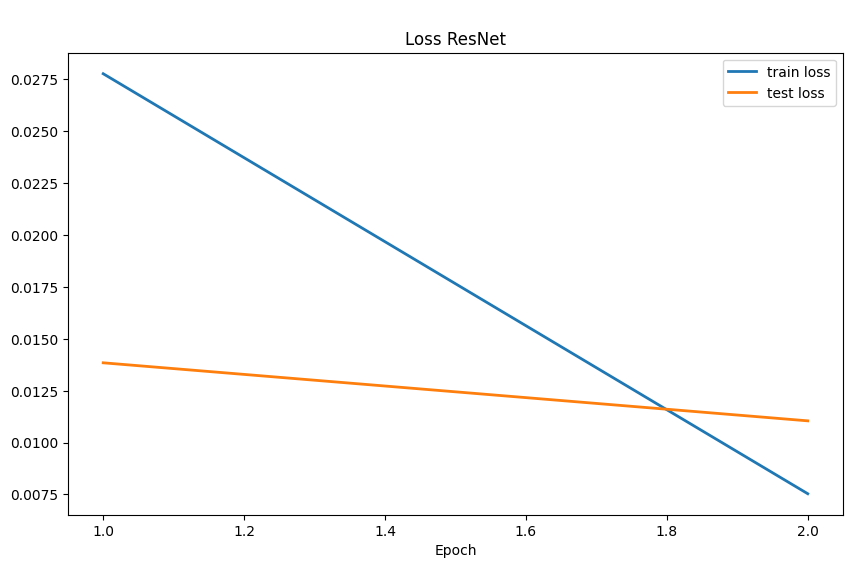

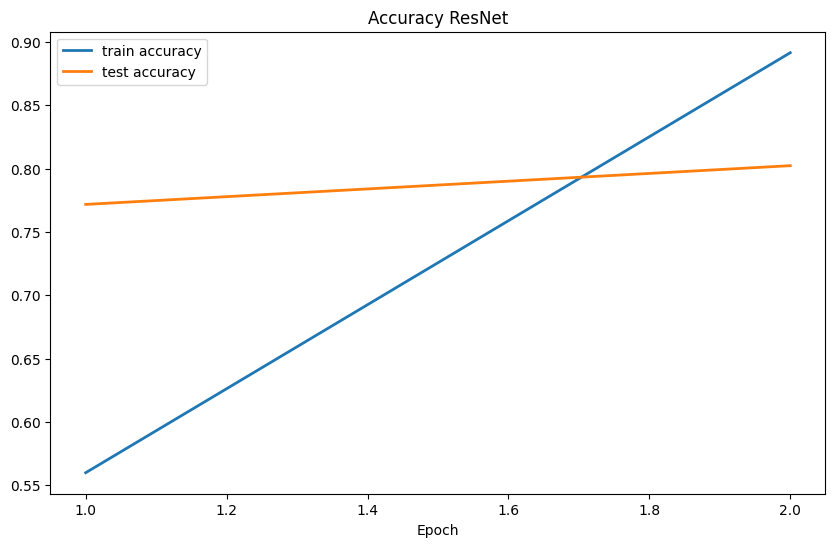


Top-3 accuracy = 0.9402173913043478
Top-5 accuracy = 0.9741847826086957


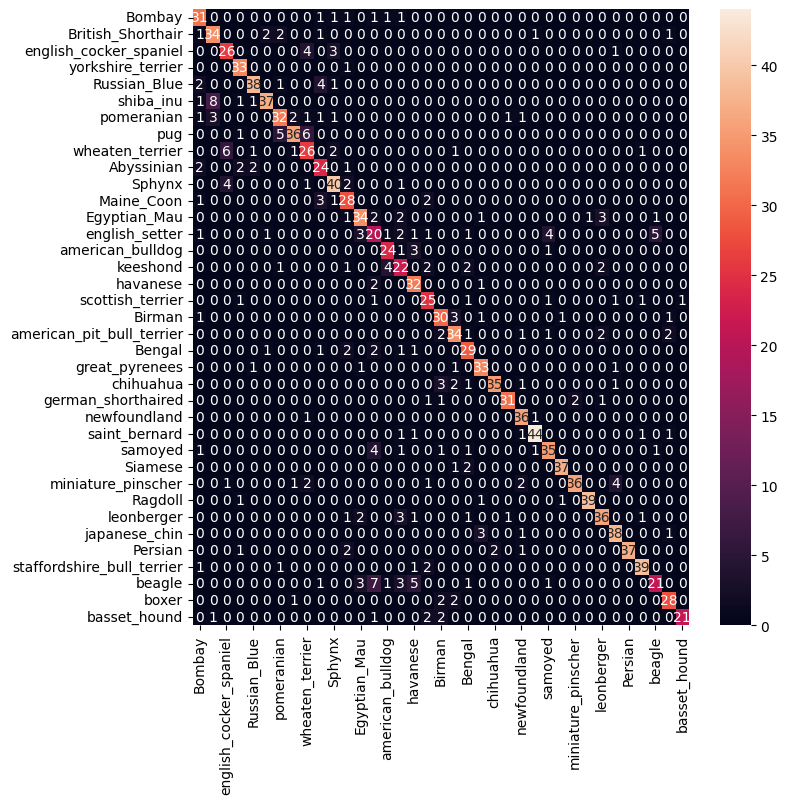

In [15]:
graf("\nLoss VGG-16", "train loss", "test loss", vgg16_stats[0], vgg16_stats[1])
graf("Accuracy VGG-16", "train accuracy", "test accuracy", vgg16_stats[2], vgg16_stats[3])

graf("\nLoss VGG-19", "train loss", "test loss", vgg19_stats[0], vgg19_stats[1])
graf("Accuracy VGG-19", "train accuracy", "test accuracy", vgg19_stats[2], vgg19_stats[3])

graf("\nLoss ResNet", "train loss", "test loss", resnet_stats[0], resnet_stats[1])
graf("Accuracy ResNet", "train accuracy", "test accuracy", resnet_stats[2], resnet_stats[3])

print('\nTop-3 accuracy =', get_top_k_accuracy(resnet, test_loader, 3))
print('Top-5 accuracy =', get_top_k_accuracy(resnet, test_loader, 5))

plot_confusion_matrix(resnet, test_loader)

Далее определим алгоритм GradCAM. Функции для загрузки изображения и определения цветовой карты

In [16]:
def load_image(img_path):
    img = Image.open(img_path).convert('RGB')
    img = transform(img).unsqueeze(0)
    return img.to(device)

def apply_colormap_on_image(org_img, activation, colormap_name='hsv'):
    # Применяем colormap
    color_map = plt.colormaps.get_cmap(colormap_name)
    no_trans_heatmap = color_map(activation)
    heatmap = copy.copy(no_trans_heatmap)
    heatmap[:, :, 3] = 0.4  # Прозрачность карты активации
    heatmap = Image.fromarray((heatmap*255).astype(np.uint8))
    no_trans_heatmap = Image.fromarray((no_trans_heatmap*255).astype(np.uint8))

    # Применяем heatmap к оригинальному изображению
    heatmap_on_image = Image.new("RGBA", org_img.size)
    heatmap_on_image = Image.alpha_composite(heatmap_on_image, org_img.convert('RGBA'))
    heatmap_on_image = Image.alpha_composite(heatmap_on_image, heatmap)
    return no_trans_heatmap, heatmap_on_image

Сам алгоритм

In [17]:
features_blobs = None
gradients = None

def extract_features_hook(module, input, output):
    global features_blobs
    features_blobs = output.data.cpu().numpy()

def extract_grad_hook(module, grad_in, grad_out):
    global gradients
    gradients = grad_out[0]

def grad_cam(model, img_tensor, target_layer, target_class=None):
    model.eval()

    # Регистрируем хуки
    handle_features = target_layer.register_forward_hook(extract_features_hook)
    handle_grad = target_layer.register_backward_hook(extract_grad_hook)

    # Forward pass
    output = model(img_tensor)

    # Если класс не задан, берем класс с максимальным выходом
    if target_class is None:
        target_class = np.argmax(output.cpu().data.numpy())

    # Создаем тензор для класса
    one_hot_output = torch.FloatTensor(1, output.size()[-1]).zero_()
    one_hot_output[0][target_class] = 1
    one_hot_output = one_hot_output.to(device)
    one_hot_output.requires_grad_(True)
    one_hot_output = torch.sum(one_hot_output * output)

    # Обратное распространение для получения градиентов
    model.zero_grad()
    one_hot_output.backward()

    # Удаляем хуки
    handle_features.remove()
    handle_grad.remove()

    # Получаем веса и применяем к карте активации
    gradients_val = gradients.cpu().data.numpy()[0, :]
    weights = np.mean(gradients_val, axis=(1, 2))
    cam = np.ones(features_blobs.shape[2:], dtype=np.float32)

    for i, w in enumerate(weights):
        cam += w * features_blobs[0, i, :, :]

    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, img_tensor.shape[2:])
    cam = cam - np.min(cam)
    cam = cam / np.max(cam)

    # Преобразуем в формат изображения
    img = img_tensor.cpu().data.numpy()[0].transpose((1, 2, 0))
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    img = np.uint8(255 * img)

    # Применяем heatmap
    heatmap, heatmap_on_image = apply_colormap_on_image(Image.fromarray(img), cam)
    
    return heatmap, heatmap_on_image

Зададим слой, для которого хотим построить карты

In [18]:
target_layer = resnet.layer4[1].conv2

Подготовим изображения и классы для визуализации

In [19]:
image_paths = ['./dataset/test/Abyssinian/Abyssinian_77.jpg',
               './dataset/test/american_bulldog/american_bulldog_44.jpg',
               './dataset/test/Birman/Birman_153.jpg',
               './dataset/test/boxer/boxer_32.jpg',
               './dataset/test/havanese/havanese_34.jpg']

target_classes = ['Abyssinian', 'american_bulldog', 'Birman', 'boxer', 'havanese']

Визуализируем

c:\Users\nikit\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


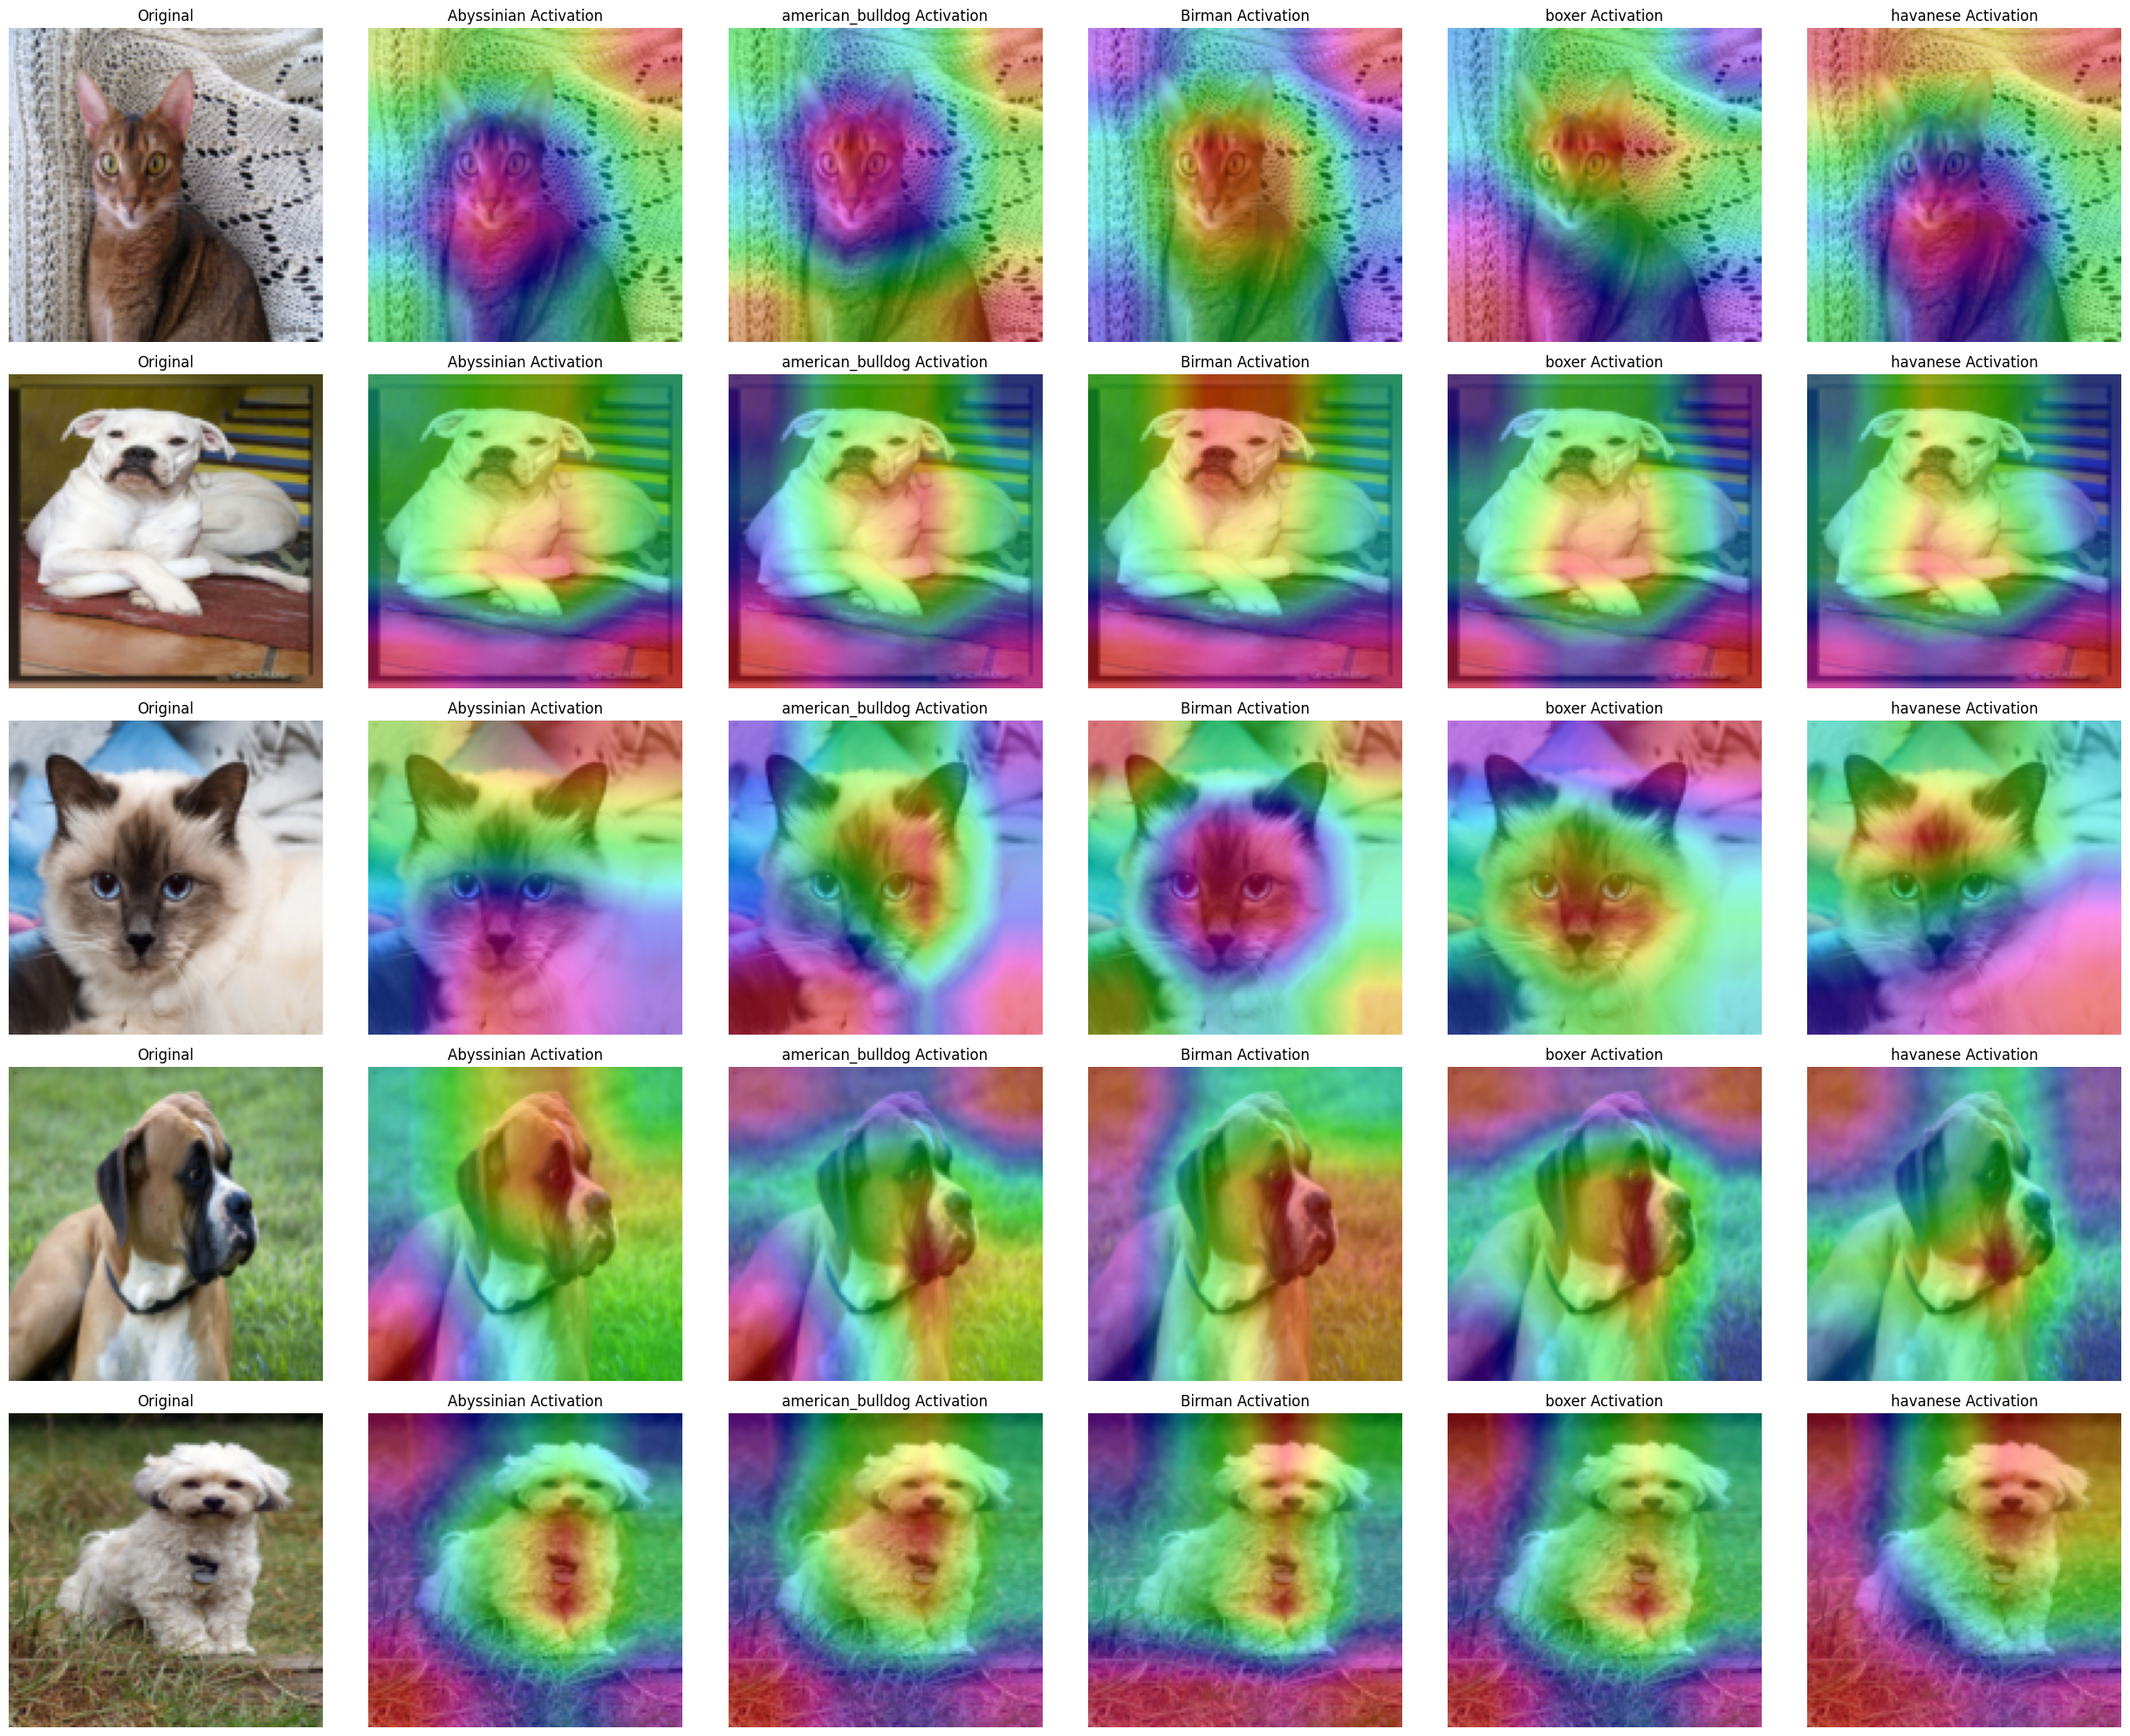

In [20]:
imgs = [load_image(path) for path in image_paths]

fig, axs = plt.subplots(len(image_paths), len(target_classes) + 1, figsize=(25, 20))

for i, img_path in enumerate(image_paths):
    img_tensor = load_image(img_path)
    img = img_tensor.cpu().data.numpy()[0].transpose((1, 2, 0))
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    img = np.uint8(255 * img)
    
    axs[i, 0].imshow(img)
    axs[i, 0].set_title('Original')
    axs[i, 0].axis('off')
    
    for j, target_class in enumerate(target_classes):
        target_index = target_classes.index(target_class)
        _, heatmap_on_image = grad_cam(resnet, img_tensor, target_layer, target_index)
        axs[i, j + 1].imshow(heatmap_on_image)
        axs[i, j + 1].set_title(f"{target_class} Activation")
        axs[i, j + 1].axis('off')

plt.tight_layout()
plt.show()